# 02807 - COMPUTATIONAL TOOLS FOR DATA SCIENCE

Group 14:
- Marco Malusà s233557
- Adrian Lopez Pirvu s232101
- Qingwen Zeng s232892
- Qiwen Huang s242640
- Matteo Piccagnoni s232713

Course's topics:
- MapReduce
- Frequent Item, A-Priory algorithm
- Graph clustering algorithms, Louvain algorithm
- TF-IDF
- Clustering, k-means

Outside course's topic:
- Linear boundaries for obsolence prediction 

This project wants to analyze a dataset of medicines to extract meaningful insights into their compositions, associated side effects, and usage patterns. The aim is to uncover patterns, relationships, and clusters within the dataset to support pharmacological research, enhance medicine recommendations, and improve understanding of medicine-side effect associations.
The project integrates multiple analytical methods, including sparse matrix analysis, market-basket analysis, community detection, and TF-IDF. Each method plays a crucial role in uncovering patterns and creating interpretable outputs.

## 1. DATA PROCESSING

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

import plotly.express as px # for interactive plots
from wordcloud import WordCloud # for wordclouds
import re  # for regular expressions

import plotly.graph_objects as go

from collections import defaultdict

import nltk
from nltk.corpus import stopwords
from sklearn.utils import murmurhash3_32
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from itertools import combinations
from community import community_louvain  # For Louvain method
import random
random.seed(42)

from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
file1 = 'medicine_details.csv'
data = pd.read_csv(file1)

print("Data from medicine_details.csv:")
data.head()

Data from medicine_details.csv:


,Medicine Name,Composition,Uses,Side_effects,Manufacturer,Excellent Review %,Average Review %,Poor Review %
0,Avastin 400mg Injection,Bevacizumab (400mg),Cancer of colon and rectum Non-small cell lung...,Rectal bleeding Taste change Headache Noseblee...,Roche Products India Pvt Ltd,22,56,22
1,Augmentin 625 Duo Tablet,Amoxycillin (500mg) + Clavulanic Acid (125mg),Treatment of Bacterial infections,Vomiting Nausea Diarrhea Mucocutaneous candidi...,Glaxo SmithKline Pharmaceuticals Ltd,47,35,18
2,Azithral 500 Tablet,Azithromycin (500mg),Treatment of Bacterial infections,Nausea Abdominal pain Diarrhea,Alembic Pharmaceuticals Ltd,39,40,21
3,Ascoril LS Syrup,Ambroxol (30mg/5ml) + Levosalbutamol (1mg/5ml)...,Treatment of Cough with mucus,Nausea Vomiting Diarrhea Upset stomach Stomach...,Glenmark Pharmaceuticals Ltd,24,41,35
4,Aciloc 150 Tablet,Ranitidine (150mg),Treatment of Gastroesophageal reflux disease (...,Headache Diarrhea Gastrointestinal disturbance,Cadila Pharmaceuticals Ltd,34,37,29


## 2. MANUFACTURER VS RATING ANALYSIS

### 2.1 FIRST ANALYSIS AND VISUALIZATION

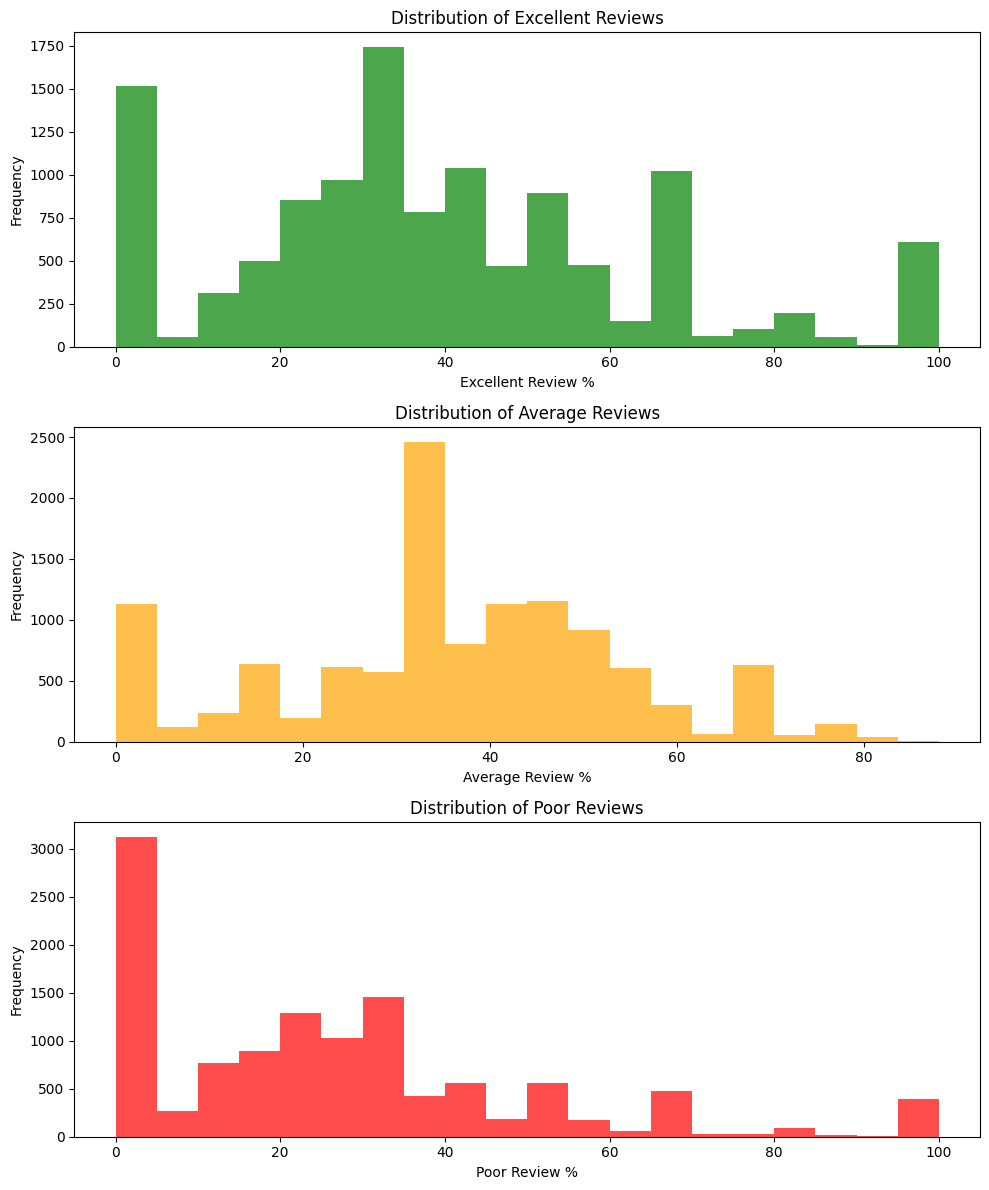

In [3]:
# three plot to see the distribution of the different percentages of reviews
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

ax1.hist(data['Excellent Review %'], bins=20, color='green', alpha=0.7)
ax1.set_title('Distribution of Excellent Reviews')
ax1.set_xlabel('Excellent Review %')
ax1.set_ylabel('Frequency')

ax2.hist(data['Average Review %'], bins=20, color='orange', alpha=0.7)
ax2.set_title('Distribution of Average Reviews')
ax2.set_xlabel('Average Review %')
ax2.set_ylabel('Frequency')

ax3.hist(data['Poor Review %'], bins=20, color='red', alpha=0.7)
ax3.set_title('Distribution of Poor Reviews')
ax3.set_xlabel('Poor Review %')
ax3.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [4]:
# Define weights for each rating category. Here we're assuming:
#   Good ratings contribute positively to the score (scaled up)
#   Middle ratings contribute a neutral or mid-range value
#   Bad ratings contribute negatively to the score (scaled down)

good_weight = 10  # Max score for good ratings
middle_weight = 5 # Midpoint score for middle ratings
bad_weight = 0    # Min score for bad ratings

# Calculate the weighted score for each observation
data['rating_score'] = (
    data['Excellent Review %'] * good_weight +
    data['Average Review %'] * middle_weight +
    data['Poor Review %'] * bad_weight
) / 100  # Divide by 100 to bring it back to a 0-10 scale

print(data[['rating_score']].head())

# save data with rating score
#data.to_csv('data_with_rating_score.csv', index=False)

   rating_score
0          5.00
1          6.45
2          5.90
3          4.45
4          5.25


In [5]:
# counting the number of manufacturers
print(data['Manufacturer'].value_counts())

Manufacturer
Sun Pharmaceutical Industries Ltd    820
Intas Pharmaceuticals Ltd            654
Cipla Ltd                            574
Torrent Pharmaceuticals Ltd          445
Lupin Ltd                            435
                                    ... 
Hicare Pharma                          1
Nexeum Pharmaceuticals                 1
Bio Swizz Pharmaceuticals              1
Nutratec Pharmaceuticals               1
Grevis Pharmaceuticals Pvt Ltd         1
Name: count, Length: 759, dtype: int64


In [6]:
# calculating the average rating for each manufacturer
manufacturer_ratings = data.groupby('Manufacturer')['rating_score'].mean().sort_values(ascending=False)
print(manufacturer_ratings)

Manufacturer
Medlius Pharma Pvt. Limited    10.0
Matias Healthcare Pvt Ltd      10.0
Ampra Pharmaceuticals          10.0
Matteo Healthcare Pvt Ltd      10.0
Lynderma Pharmaceuticals       10.0
                               ... 
Nicholas Healthcare Limited     0.0
Astra Labs                      0.0
Baxton Pharmacia                0.0
Arlak Biotech Pvt Ltd           0.0
Aarti Life Science              0.0
Name: rating_score, Length: 759, dtype: float64


In [7]:
# interactive plot to visualize the average ratings by manufacturer
# you can zoom in and out, hover over the bars to see the values
fig = px.bar(
    x=manufacturer_ratings.index,
    y=manufacturer_ratings.values,
    title='Average Ratings by Manufacturer',
    labels={'x': 'Manufacturer', 'y': 'Average Rating'}
)

fig.update_layout(
    height=600,
    width=2000, # number of manufacturers
    xaxis_tickangle=45,
    showlegend=False
)

### 2.1 CLUSTERING

Using the following code, we perform manufacturer clustering based on their ratings and their contribution to overall medicine production. This analysis helps identify which manufacturers are most prominent within each rating cluster. To prevent the most prolific manufacturers from dominating every cluster, we weighted their presence in each cluster by the total number of medicines they produce.

In [8]:
# Convert to DataFrame
df = pd.DataFrame(data)

# Extract the 'Rating' column for clustering
ratings = df[['rating_score']]

# Perform K-Means clustering with k=4
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(ratings)

In [9]:
# Calculate the mean rating for each cluster
cluster_means = df.groupby('Cluster')['rating_score'].mean()

# Sort clusters by mean rating in descending order
sorted_clusters = cluster_means.sort_values(ascending=False).index

# Map the original clusters to the sorted clusters
cluster_mapping = {old: new for new, old in enumerate(sorted_clusters)}
df['Cluster'] = df['Cluster'].map(cluster_mapping)

# Sort by cluster index to maintain consistency in the order of clusters
cluster_counts = df['Cluster'].value_counts().sort_index()

# Define a consistent color map for clusters (fixed colors for each cluster)
cluster_color_map = {0: 'blue', 1: 'red', 2: 'green', 3: 'orange'}


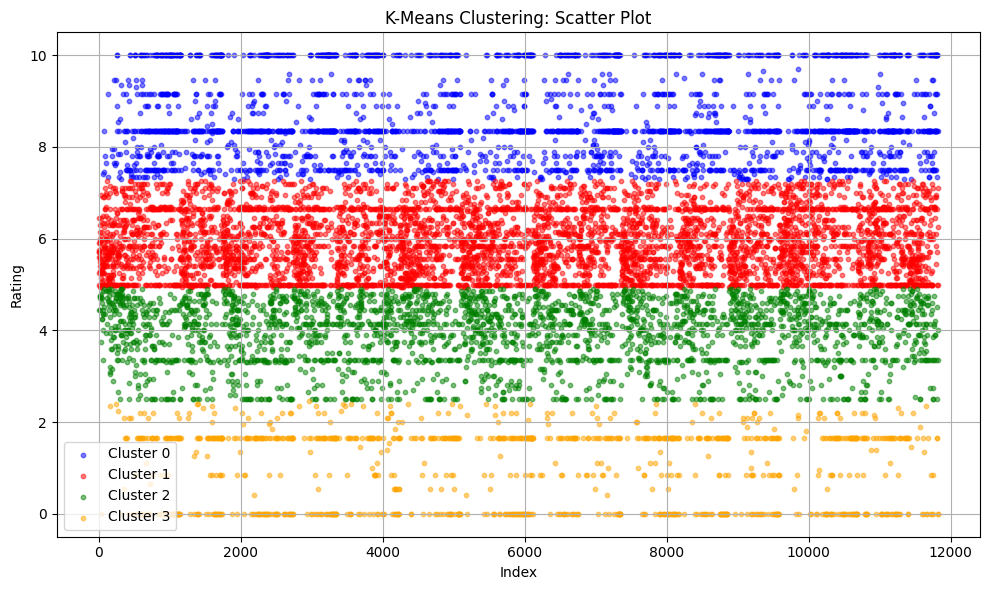

In [10]:
# Scatter plot with consistent colors based on clusters
plt.figure(figsize=(10, 6))

# Plot each cluster using its fixed color
for cluster in range(4):
    cluster_data = df[df['Cluster'] == cluster]
    plt.scatter(
        cluster_data.index,
        cluster_data['rating_score'],
        label=f'Cluster {cluster}',
        color=cluster_color_map[cluster],  # Use fixed color
        s=10,
        alpha=0.5  # Transparency for overlapping points
    )

plt.title("K-Means Clustering: Scatter Plot")
plt.xlabel("Index")
plt.ylabel("Rating")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

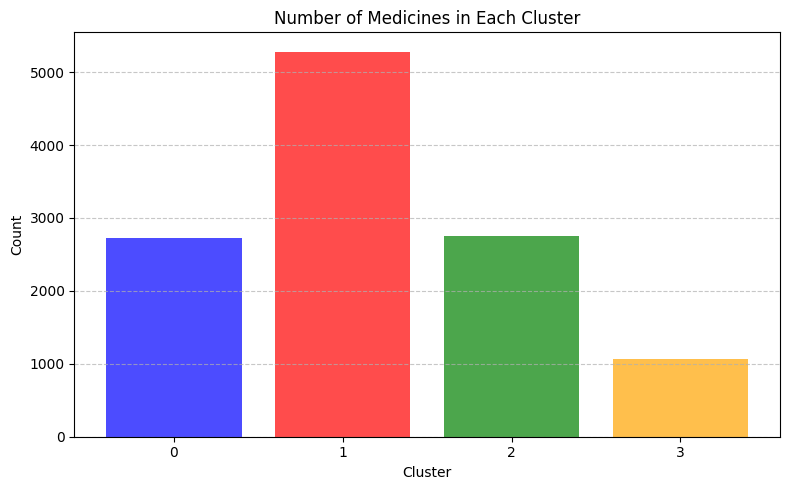

In [11]:
# Bar plot with consistent colors based on clusters, keeping original cluster order
plt.figure(figsize=(8, 5))

# Use the same color map and the original cluster order
plt.bar(
    cluster_counts.index,  # Keep the original cluster order from the clustering
    cluster_counts.values, 
    color=[cluster_color_map[cluster] for cluster in cluster_counts.index],  # Keep color consistent
    alpha=0.7
)

plt.title("Number of Medicines in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.xticks(range(4))  # Ensure x-axis corresponds to clusters 0, 1, 2, 3
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

As shown in the plot, Cluster 1, which contains medicines with ratings between 5 and 7, is the most populous cluster. In contrast, Cluster 3, which includes medicines with ratings between 0 and 2, is the least populated. This observation is also supported by the scatter plot. 

In [12]:
# Count the number of medicines per manufacturer in each cluster
manufacturer_cluster_matrix = df.groupby(['Cluster', 'Manufacturer']).size().unstack(fill_value=0)

# Find the top 2 manufacturers in each cluster
top_manufacturers_per_cluster = (
    manufacturer_cluster_matrix.apply(lambda row: row.nlargest(2).index.tolist(), axis=1)
)

# Step 1: Create the manufacturer-cluster matrix (count the occurrences of each manufacturer in each cluster)
manufacturer_cluster_matrix = pd.crosstab(df['Cluster'], df['Manufacturer'])

# Step 2: Compute the total number of medicines each manufacturer produces (count the appearances in the 'Manufacturer' column)
manufacturer_medicine_count = df['Manufacturer'].value_counts().to_dict()


# Step 3: Calculate the weighted presence of manufacturers in each cluster and find the top 2 manufacturers per cluster
top_manufacturers_per_cluster = {}

for cluster, manufacturers in manufacturer_cluster_matrix.iterrows():
    manufacturer_weights = {}

    # For each manufacturer in the cluster, calculate the weighted presence
    for manufacturer, count in manufacturers.items():
        if count > 0:  # Only consider manufacturers that appear in the cluster
            # Weighting the appearance by the proportion of the manufacturer's total medicines that appear in this cluster
            weighted_count = count / manufacturer_medicine_count.get(manufacturer, 1)  # Prevent division by zero
            manufacturer_weights[manufacturer] = manufacturer_weights.get(manufacturer, 0) + weighted_count
    
    # Sort the manufacturers by the weighted presence in descending order
    sorted_manufacturers = sorted(manufacturer_weights.items(), key=lambda x: x[1], reverse=True)
    
    # Get the top 2 manufacturers
    top_manufacturers_per_cluster[cluster] = [sorted_manufacturers[0][0], sorted_manufacturers[1][0]] if len(sorted_manufacturers) > 1 else [sorted_manufacturers[0][0]]

# Step 4: Display the top 2 manufacturers per cluster
print("\nTop 2 Manufacturers per Cluster (Proportioned by Medicine Production):")
for cluster, manufacturers in top_manufacturers_per_cluster.items():
    print(f"Cluster {cluster}: {manufacturers[0]} and {manufacturers[1]}")


Top 2 Manufacturers per Cluster (Proportioned by Medicine Production):
Cluster 0: ADN Life Sciences and ADZO Lifesciences Pvt Ltd
Cluster 1: AAA Pharma Trade Pvt Ltd and AS Lifesciences
Cluster 2: Aprazer Healthcare Pvt Ltd and Arjan Biotech
Cluster 3: Aarti Life Science and Adonis Phytoceuticals Pvt Ltd


The manufacturers listed above are the most prominent in each cluster, weighted by the number of medicines they produce. This helps identify which manufacturers dominate each cluster, providing insight into their overall performance and quality.

## 3. SIDE EFFECT APPEREANCES 

Using a word cloud plot we want to see and visualize which are the most common side effects in our dataset

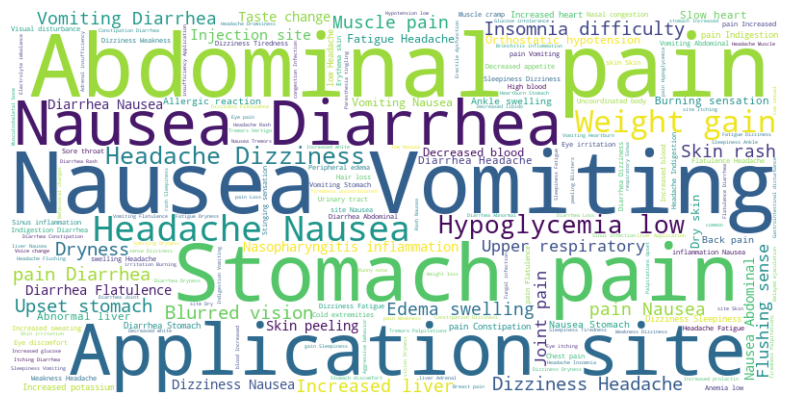

In [13]:
# Step 1: Split side effects based on capital letters and clean up the list
data['Side_effects'] = data['Side_effects'].apply(lambda x: re.findall(r'[A-Z][a-z]*\s?[a-z]*', x))

# Step 2: Combine all side effects into a single string for word cloud
all_side_effects = ' '.join([' '.join(effect) for effect in data['Side_effects']])

# Step 3: Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_side_effects)

# Step 4: Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Visualizing the occurrence of side effects using a word cloud is an engaging way to explore the relationship between drug components and their associated side effects, as we will demonstrate in the following section of the notebook.

## 4. SPARSE MATRIX and BASKET ANALYSIS

### 4.1 Sparse Matrix Representation and Analysis

This section focuses on converting the medicine composition data into a sparse matrix format for efficient storage and processing. 
The steps include:
- Mapping Components: Assigning unique indices to components for a more compact representation.
- Sparse Matrix Conversion: Replacing component names with indices in the DataFrame.
- Sparsity Analysis: Calculating the percentage of zero and non-zero elements to understand the data distribution.
- Tuple-Based Representation: Extracting non-zero elements into tuples for efficient storage and further processing.
- Reverse Mapping: Mapping indices back to original component names for interpretation.


This code defines two functions to process and organize data about medicine compositions. The **map_composition** function extracts detailed information about each medicine's components, including their names and quantities, while the **reduce_components** function aggregates this information into a structured format, showing the quantities of each unique component for all medicines.

In [14]:
# Map function to parse compositions and emit intermediate results
def map_composition(row):
    medicine_name = row["Medicine Name"]
    composition = row["Composition"]
    
    components = []
    for component in composition.split("+"):
        component = component.strip()
        name, quantity = component.rsplit("(", 1)
        name = name.strip()
        quantity = quantity.strip(")")
        components.append((medicine_name, name, quantity))
    return components

# Reduce function to aggregate results into a final structure
def reduce_components(mapped_data):
    # Collect all unique components
    unique_components = set()
    for entry in mapped_data:
        _, component_name, _ = entry
        unique_components.add(component_name)
    
    # Initialize the result structure
    result = defaultdict(lambda: {component: "" for component in unique_components})
    
    # Populate the structure with quantities
    for medicine_name, component_name, quantity in mapped_data:
        result[medicine_name][component_name] = quantity
    
    return result

In [15]:
# Read the first two columns of the data
df = pd.read_csv('./medicine_details.csv', usecols=[0,1])
df.head()

# Apply the map function to all rows
mapped_data = []
for _, row in df.iterrows():
    mapped_data.extend(map_composition(row))

# Apply the reduce function
reduced_data = reduce_components(mapped_data)

# Convert the reduced data to a DataFrame
final_df = pd.DataFrame.from_dict(reduced_data, orient="index").reset_index()
final_df.rename(columns={"index": "Medicine Name"}, inplace=True)

# Display the final DataFrame
final_df

,Medicine Name,Papain,Apixaban,Ammonium Chloride,Insulin Glargine,Freeze-dried Live Attenuated Hepatitis A Vaccine,Procyclidine,Vancomycin,Potassium Clavulanate,Glycolic acid,...,Testosterone Propionate,Terpin Hydrate,Levocetirizine,Pantothenic Acid (Vitamin B5),Clonidine,Fluconazole,Thiamine(Vitamin B1),Artemether,Adapalene,Pancreatin
0,Avastin 400mg Injection,,,,,,,,,,...,,,,,,,,,,
1,Augmentin 625 Duo Tablet,,,,,,,,,,...,,,,,,,,,,
2,Azithral 500 Tablet,,,,,,,,,,...,,,,,,,,,,
3,Ascoril LS Syrup,,,,,,,,,,...,,,,,,,,,,
4,Aciloc 150 Tablet,,,,,,,,,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11493,Zenegra Lido Spray,,,,,,,,,,...,,,,,,,,,,
11494,Zilarta-CT 40/6.25 Tablet,,,,,,,,,,...,,,,,,,,,,
11495,Zipcoz Tablet,,,,,,,,,,...,,,,,,,,,,
11496,Zestasil 100 Tablet,,,,,,,,,,...,,,,,,,,,,


This part of the code assigns a unique index to each distinct value in the DataFrame (excluding empty strings) and replaces the original values with their corresponding indices. This transformation is likely preparing the data for further processing, such as creating a sparse matrix.

In [16]:
# Get unique values from the DataFrame (excluding "")
unique_values = sorted(set(final_df.values.flatten()) - {""})
value_mapping = {v: i for i, v in enumerate(unique_values)}  # Map each unique value to an index
# Display first 5 unique values and their corresponding indices
print("\nValue Mapping:")
for value, index in list(value_mapping.items())[:5]:
    print(f"{value} -> {index}")

# Replace DataFrame values with indices
sparse_matrix = final_df.set_index("Medicine Name").map(lambda x: value_mapping.get(x, -1)) # TODO If only presence is required (probably for market item), replace the get function with a lambda function that returns 1 if x is not -1 else 0
sparse_matrix.head(5)


Value Mapping:
0.0003% w/w -> 0
0.0007ml -> 1
0.001% w/v -> 2
0.0015% w/v -> 3
0.002% w/w -> 4


,Papain,Apixaban,Ammonium Chloride,Insulin Glargine,Freeze-dried Live Attenuated Hepatitis A Vaccine,Procyclidine,Vancomycin,Potassium Clavulanate,Glycolic acid,Fructo Oligosaccharide,...,Testosterone Propionate,Terpin Hydrate,Levocetirizine,Pantothenic Acid (Vitamin B5),Clonidine,Fluconazole,Thiamine(Vitamin B1),Artemether,Adapalene,Pancreatin
Medicine Name,,,,,,,,,,,,,,,,,,,,,
Avastin 400mg Injection,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Augmentin 625 Duo Tablet,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Azithral 500 Tablet,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Ascoril LS Syrup,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Aciloc 150 Tablet,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


This code analyzes sparsity and non-zero elements in the sparse matrix.

In [17]:
# Calculate statistics
total_elements = sparse_matrix.size
total_zeros = (sparse_matrix == -1).sum().sum()
total_non_zeros = total_elements - total_zeros
percentage_zeros = (total_zeros / total_elements) * 100

print("Sparse Matrix Statistics:")
print(f"Total elements: {total_elements}")
print(f"Number of zeros: {total_zeros}")
print(f"Number of non-zeros: {total_non_zeros}")
print(f"Percentage of zeros: {percentage_zeros:.2f}%")

Sparse Matrix Statistics:
Total elements: 12199378
Number of zeros: 12181760
Number of non-zeros: 17618
Percentage of zeros: 99.86%


This code extracts non-zero elements as tuples for efficient storage and processing.

In [18]:
row_array = sparse_matrix.index.tolist()
column_array = sparse_matrix.columns.tolist()

# Create a list of tuples (row_index, column_index, value) for non-zero values
non_zero_tuples = [
    (row_idx, col_idx, sparse_matrix.iloc[row_idx, col_idx])
    for row_idx in range(sparse_matrix.shape[0])
    for col_idx in range(sparse_matrix.shape[1])
    if sparse_matrix.iloc[row_idx, col_idx] != -1
]

This code create a reverse map indices to their original component names for readability.

In [19]:
# This dictionary maps each unique value to its index
reverse_mapping = {i: v for v, i in value_mapping.items()}  # Reverse the dictionary to get values from indices

# Print some tuples along with their components
print("Sample tuples with indexed values and their components:")
for i, (row_idx, col_idx, value_index) in enumerate(non_zero_tuples[:5]):  # Limit to first 5 tuples
    original_value = reverse_mapping.get(value_index, "Unknown")  # Get the original value using the reverse mapping
    print(f"Tuple {i+1}: (Row: {row_idx}, Column: {col_idx}, Indexed Value: {value_index}, Original Component: {original_value})")

Sample tuples with indexed values and their components:
Tuple 1: (Row: 0, Column: 1005, Indexed Value: 472, Original Component: 400mg)
Tuple 2: (Row: 1, Column: 377, Indexed Value: 521, Original Component: 500mg)
Tuple 3: (Row: 1, Column: 574, Indexed Value: 220, Original Component: 125mg)
Tuple 4: (Row: 2, Column: 126, Indexed Value: 521, Original Component: 500mg)
Tuple 5: (Row: 3, Column: 256, Indexed Value: 286, Original Component: 1mg/5ml)


These transformations allow for scalable processing of large datasets and facilitate operations such as similarity computation or recommendation systems based on medicine composition.

### 4.2 Market-Basket Analysis


In this part, the aim is to uncover relationships between medicine components and their associated side effects using a market basket analysis approach. Here, this methodology was adapted to explore frequent combinations of components in medicines and associate them with potential side effects.
Understanding these associations can help to identify common side effects caused by frequently occurring combinations of components, support pharmacological research and improve medical recommendations.
The steps are:
- Data Preparation: Extract and clean the dataset, organizing medicine compositions and their associated side effects into transactions.
- Frequent Itemset Mining: Apply the A-Priori algorithm to identify common combinations of medicine components based on a minimum support threshold.
- Association Mapping: Link frequent itemsets with their reported side effects, creating a mapping of component combinations to potential effects.
- Insight Extraction: Display and interpret the associations between medicine compositions and side effects to uncover actionable patterns.

These following functions are: **split_side_effects**, extracts individual side effects from a text string using a pattern for words starting with uppercase letters; **count_compositions**, determines the number of components in a chemical composition by splitting the string on '+' symbols; **a_priori**, implements the A-Priori algorithm to find frequent itemsets in transaction data, filtering them based on a minimum support threshold.

In [20]:
def split_side_effects(side_effects):
    # Regular expression to match words starting with uppercase letters (and followed by lowercase letters)
    return re.findall(r'[A-Z][a-z]*\s?[a-z]*', side_effects)

# Function to count the number of components in a chemical composition
def count_compositions(composition):
    # Split the composition string by '+' to identify individual components
    components = composition.split('+')
    return len(components)

# Function to apply the A-Priori algorithm
def a_priori(transactions, min_support):
    
    # Count occurrences of individual items
    item_counts = defaultdict(int)
    for transaction in transactions.values():
        for item in transaction:
            item_counts[item] += 1

    # Calculate the number of transactions
    num_transactions = len(transactions)

    # Identify frequent 1-itemsets
    frequent_itemsets = {item: count / num_transactions for item, count in item_counts.items() if count / num_transactions >= min_support}

    # Initialize variables to find larger itemsets
    current_itemsets = list(frequent_itemsets.keys())  # Start with frequent 1-itemsets
    all_frequent_itemsets = dict(frequent_itemsets)  # Store all discovered frequent itemsets
    k = 2  # Length of itemsets to generate

    # Iteratively find larger itemsets
    while current_itemsets:
        next_itemsets = defaultdict(int)

        # Generate candidate k-itemsets and count their occurrences
        for transaction in transactions.values():
            for itemset in combinations(transaction, k):
                if all(item in transaction for item in itemset):
                    next_itemsets[itemset] += 1
        
        # Filter k-itemsets based on the minimum support threshold
        frequent_itemsets_k = {itemset: count / num_transactions for itemset, count in next_itemsets.items() if count / num_transactions >= min_support}

        # Stop if no new frequent itemsets are found
        if not frequent_itemsets_k:
            break
        
        # Update the overall list of frequent itemsets
        all_frequent_itemsets.update(frequent_itemsets_k)
        current_itemsets = list(frequent_itemsets_k.keys())
        k += 1  # Increase itemset size for the next iteration

    return all_frequent_itemsets

This code creates two dictionaries, **transactions** and **side_effects_dict**, which are essential for the analysis of compositions and side effects.

In [ ]:
df = pd.read_csv('./medicine_details.csv')

transactions = defaultdict(set)  # To hold compositions
side_effects_dict = defaultdict(list)  # To hold side effects

# Create a dictionary to hold the result
medicine_to_compositions = {}

# Iterate through the non-zero tuples and populate the dictionary
for row_idx, col_idx, value_index in non_zero_tuples:
    # Get the corresponding medicine name (row label)
    medicine_name = sparse_matrix.index[row_idx]
    
    # Get the corresponding component name (from reverse mapping)
    component_name = reverse_mapping.get(value_index, "Unknown")
    
    # If the medicine is not in the dictionary, add it with an empty list
    if medicine_name not in medicine_to_compositions:
        medicine_to_compositions[medicine_name] = []
    
    # Add the component to the list for this medicine
    medicine_to_compositions[medicine_name].append(component_name)

# Convert the list of components into a single string with "+" separated components
for medicine_name, components in medicine_to_compositions.items():
    # Join the components with '+' and store it back
    medicine_to_compositions[medicine_name] = " + ".join(components)

for _, row in df.iterrows():
    # Each medicine is a transaction of components
    composition = row["Composition"].split(' + ')  # Split multiple ingredients
    transactions[row["Medicine Name"]] = composition
    # Store side effects associated with each medicine (using the regex split function)
    side_effects = split_side_effects(row["Side_effects"])
    side_effects_dict[row["Medicine Name"]] = side_effects

The following code counts the number of components in each medicine's composition and then calculates statistics about the frequency of these counts.

In [22]:
# Function to count the number of components in a chemical composition
def count_compositions(composition):
    # Split the composition string by '+' to identify individual components
    components = composition.split('+')
    return len(components)

# Add a new column to the DataFrame to store the composition counts
df['Composition Count'] = df['Composition'].apply(count_compositions)

# Calculate statistics for the number of components (composition counts)
composition_count_stats = df['Composition Count'].value_counts().sort_index()

# Convert the composition count statistics to a DataFrame for table output
composition_count_stats_df = composition_count_stats.reset_index()
composition_count_stats_df.columns = ['Number of Components', 'Frequency']

# Display the statistics as a table
composition_count_stats_df.sort_values(by='Number of Components', ascending=True)


,Number of Components,Frequency
0,1,7069
1,2,3596
2,3,933
3,4,150
4,5,51
5,6,16
6,7,7
7,8,2
8,9,1


Implementation of an A-priori algorithm for finding frequent itemsets in transactional data. It is used to dentify which components (or combinations of components) are commonly used in medicines.

In [ ]:
# Apply the A-Priori algorithm to the transactional data
min_support = 0.003  # Support threshold
frequent_itemsets = a_priori(transactions, min_support)

df_results = pd.DataFrame(
    [(itemset, support) for itemset, support in frequent_itemsets.items()],
    columns=["Itemset", "Support"]
).sort_values(by="Support", ascending=False)

# top 5 frequent itemsets in a table format
df_results.head()


,Itemset,Support
32,Metformin (500mg),0.039224
23,Telmisartan (40mg),0.024613
17,Amlodipine (5mg),0.022613
21,Hydrochlorothiazide (12.5mg),0.016264
22,Glimepiride (2mg),0.015916


The following code identifies the side effects associated with each frequent itemset found using the A-Priori algorithm, enabling the analysis of relationships between groups of medicine components and their potential side effects. It then visualizes these associations with a Sankey diagram, illustrating the flow from medicine combinations (source nodes) to their related side effects (target nodes) in an interactive format.

In [26]:
# Create a dictionary to map medicine combinations (itemsets) to their associated side effects
itemset_side_effects = defaultdict(set)

# Loop through transactions to associate itemsets with side effects
for medicine_name, components in transactions.items():
    # Retrieve the side effects associated with the current medicine
    side_effects = side_effects_dict[medicine_name]
    
    # Iterate through all frequent itemsets
    for itemset in frequent_itemsets:
        # Sort the itemset to ensure consistent ordering
        sorted_itemset = tuple(sorted(itemset))
        
        # Check if all items in the itemset are present in the medicine components
        if all(item in components for item in itemset):
            # Add the side effects of the medicine to the current itemset
            itemset_side_effects[sorted_itemset].update(side_effects)

# Prepare data for the Sankey diagram
node_labels = []       # Labels for all nodes (medicine combinations + side effects)
links_source = []      # Source node indices
links_target = []      # Target node indices
links_value = []       # Flow values (e.g., set to 1 or a measure of strength)

# Construct nodes and links
node_set = set()        # Set to store unique nodes
for itemset, side_effects in itemset_side_effects.items():
    # Convert the medicine combination (itemset) to a string label
    itemset_label = ", ".join(itemset)
    if itemset_label not in node_set:
        # Add unique medicine combination node
        node_set.add(itemset_label)
        node_labels.append(itemset_label)
    
    # Add side effect nodes and create links
    for effect in side_effects:
        if effect not in node_set:
            # Add unique side effect node
            node_set.add(effect)
            node_labels.append(effect)
        
        # Create links between the medicine combination and side effect
        links_source.append(node_labels.index(itemset_label))
        links_target.append(node_labels.index(effect))
        links_value.append(1)  # Set link weight to 1 (can be adjusted if needed)

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=180,          # Padding between nodes
        thickness=75,     # Thickness of the nodes
        line=dict(color="black", width=0.1),  # Node borders
        label=node_labels  # Node labels
    ),
    link=dict(
        source=links_source,  # Source node indices
        target=links_target,  # Target node indices
        value=links_value     # Flow values
    )
))

# Customize layout and display the figure
fig.update_layout(
    title_text="Medicine Combinations and Associated Side Effects",  # Title of the diagram
    font=dict(size=8, color="black"),    # Font settings for labels
    plot_bgcolor="white",                # Background color of the plot
    width=800,                           # Diagram width
    height=1000                          # Diagram height
)
fig.show()


## 5. Community Detection
Identify and group similar documents into communities based on their content using Minhashing and Locality Sensitive Hashing (LSH). The steps are: 
- Data Preprocessing: The dataset is cleaned by removing stopwords and unnecessary terms from the Uses column to ensure meaningful comparisons.
- Shingle Generation: Documents are split into overlapping sequences of words (k-shingles) to represent their content.
- Minhashing: A signature matrix is created for each document to approximate the Jaccard similarity between documents efficiently.
- Locality Sensitive Hashing (LSH): Documents are grouped into buckets based on their Minhash signatures to find potential candidate pairs for similarity analysis.
- Graph Construction: A graph is built with documents as nodes and edges representing potential similarities above a threshold (e.g., Jaccard similarity > 0.8).
- Community Detection: The Louvain method is applied to detect communities within the graph, grouping documents based on shared content.

Load the dataset and clean the text data by removing stopwords and specific terms.

In [28]:
#set random seed
random.seed(42)
# Download NLTK stopwords
nltk.download('stopwords')

# Load data
file_path = 'medicine_details.csv'
data = pd.read_csv(file_path)

# Text preprocessing: remove stopwords and specific terms
stop_words = set(stopwords.words('english'))
stop_words.add('treatment')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matteopiccagnoni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


These functions process text data to analyze similarity between documents. The **clean_text** function removes stopwords and parentheses while preserving the content inside them. The **create_shingles** function generates k-shingles (n-grams) from the cleaned text, preparing it for comparison. The **minhash_signature** function computes a MinHash signature for a set of shingles, enabling efficient similarity measurement. Finally, the **lsh** function uses Locality Sensitive Hashing (LSH) to group similar documents based on their MinHash signatures.

In [29]:
# Remove stopwords and parentheses without removing their content
def clean_text(text):
    """
    Remove stopwords and parentheses '(' and ')', but keep the content inside parentheses.
    """
    # Remove parentheses while keeping their content
    text = re.sub(r'[()]', '', text)
    # Remove stopwords
    words = [word for word in text.split() if word.lower() not in stop_words]
    return ' '.join(words)

# Apply to the 'Uses' column
data['Uses'] = data['Uses'].apply(lambda x: clean_text(str(x)))


# Function to generate shingles
def create_shingles(text, k=3):
    """
    Split text into k-shingles (n-grams of size k).
    """
    words = text.split()
    if len(words) < k:
        return set(words)
    return set([' '.join(words[i:i+k]) for i in range(len(words) - k + 1)])

# Minhash signature 
def minhash_signature(shingles, n_hashes, shingle_to_idx):
    """
    Generate a Minhash signature for a set of shingles.
    """
    signature = np.full(n_hashes, np.inf)
    for shingle in shingles:
        shingle_idx = shingle_to_idx[shingle]
        for i, h in enumerate(hash_functions):
            signature[i] = min(signature[i], h(str(shingle_idx)))
    return signature

# Locality Sensitive Hashing (LSH)
def lsh(signatures, bands, rows):
    """
    Perform Locality Sensitive Hashing (LSH) to group similar documents.
    """
    buckets = {}
    for doc_id, signature in enumerate(signatures):
        for band in range(bands):
            band_signature = tuple(signature[band*rows:(band+1)*rows])
            if band_signature not in buckets:
                buckets[band_signature] = []
            buckets[band_signature].append(doc_id)
    return buckets

Create a mapping from shingles to indices for use in the Minhashing process.

In [30]:
# Generate shingles for each document
k = 3  # Size of shingles
data['Shingles'] = data['Uses'].apply(lambda x: create_shingles(str(x)))

# Create the universe of shingles and map them to indices
all_shingles = set().union(*data['Shingles'])
shingle_to_idx = {shingle: idx for idx, shingle in enumerate(all_shingles)}

Generate Minhash signatures for each document to approximate the Jaccard similarity between sets of shingles.

In [31]:
# Minhashing
n_hashes = 100  # Number of hash functions
hash_functions = [lambda x, seed=seed: murmurhash3_32(x, seed=seed) for seed in range(n_hashes)]

data['Minhash'] = data['Shingles'].apply(lambda x: minhash_signature(x, n_hashes, shingle_to_idx))

Group similar documents using LSH to identify potential candidate pairs for similarity analysis.

In [32]:
bands = 20  # Number of bands
rows = n_hashes // bands  # Rows per band
lsh_buckets = lsh(data['Minhash'], bands, rows)

Identify potential similar document pairs based on LSH buckets.

In [33]:
# Find potential similar document pairs
similar_pairs = set()
for bucket_docs in lsh_buckets.values():
    if len(bucket_docs) > 1:
        similar_pairs.update(combinations(bucket_docs, 2))

The following code construct a graph of documents and add edges based on the Jaccard similarity between shingles.

In [34]:
# Build a graph of similar documents
G = nx.Graph()
G.add_nodes_from(range(len(data)))  # Add nodes for each document

# Add edges based on similar pairs
for doc1, doc2 in similar_pairs:
    shingles1 = data.loc[doc1, 'Shingles']
    shingles2 = data.loc[doc2, 'Shingles']
    # Compute Jaccard similarity
    jaccard_sim = len(shingles1 & shingles2) / len(shingles1 | shingles2)
    if jaccard_sim > 0.8:  # Similarity threshold
        G.add_edge(doc1, doc2, weight=jaccard_sim)


Apply the Louvain method to detect communities in the graph based on edge weights.

In [35]:
# Apply Louvain community detection
partition = community_louvain.best_partition(G, weight='weight')

# Add community labels to the graph as node attributes
nx.set_node_attributes(G, partition, 'community')

# Save the graph with communities
nx.write_gexf(G, 'graph_with_communities.gexf')

# Add community labels to the dataframe
data['Community'] = data.index.map(partition)

# Save the data with community information
#data.to_csv('data_with_communities.csv', index=False)

Print the statistics of the graph and the detected communities

In [36]:
# Print summary
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())
print('Number of communities:', len(set(partition.values())))
print('Modularity:', community_louvain.modularity(partition, G))

Number of nodes: 11825
Number of edges: 1221210
Number of communities: 598
Modularity: 0.8302334745347961


The modularity value of 0.83 means that the the graph can be divided into communities. This suggests that the structure of the network has a significant number of edges within the communities compared to the number of edges between communities, making the division into communities meaningful.

The following code shows the top 5 biggest community found and their maine usage. 

In [37]:
community_sizes = {}
for community_id in partition.values():
    if community_id not in community_sizes:
        community_sizes[community_id] = 0
    community_sizes[community_id] += 1

sorted_community_sizes = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)

top_5_communities = sorted_community_sizes[:5]

print("Top 5 Biggest Communities:")
for community_id, size in top_5_communities:
    print(f"Community ID: {community_id}, Size: {size}")

Top 5 Biggest Communities:
Community ID: 459, Size: 907
Community ID: 168, Size: 684
Community ID: 406, Size: 508
Community ID: 15, Size: 385
Community ID: 13, Size: 363


In [38]:
community_sizes = data['Community'].value_counts()

top_5_communities = community_sizes.head(5).index

for community_id in top_5_communities:
    print(f"Community ID {community_id}:")
    uses_in_community = data[data['Community'] == community_id]['Uses']
    
    most_common_use = uses_in_community.mode()[0]  # mode()[0] to get the most common use as a string
    print(f"  - Most common use: {most_common_use}")

Community ID 459:
  - Most common use: Type 2 diabetes mellitus
Community ID 168:
  - Most common use: Hypertension high blood pressure
Community ID 406:
  - Most common use: Bacterial infections
Community ID 15:
  - Most common use: Pain relief
Community ID 13:
  - Most common use: Fungal skin infections


The output above shows the predominant uses within the top 5 most populated communities, providing insight into their composition and characteristics.

## 6. TF-IDF 
The purpose of this section is to analyze communities identified in the dataset and visualize their content using TF-IDF scores and word clouds. This helps in understanding the most significant terms within each community for different columns ('Uses', 'Composition', and 'Side Effects'). The visualization aids in uncovering patterns and insights about the documents grouped into communities.
The steps are:
- Identify Top Communities: Extract the indices of the top communities for analysis.
- Calculate TF-IDF Scores: Define a function to compute TF-IDF scores for words in the documents of each community.
- Select Top Words by TF-IDF: Create a function to select the most significant words from the TF-IDF scores.
- Map Community Names: Assign names to communities based on the top words from the TF-IDF analysis.
- Rename Communities in the DataFrame: Add the community names to the DataFrame as a new column.
- Generate Word Clouds for 'Uses' Column: Create and plot word clouds to visualize the most important words for each community in the 'Uses' column.
- Repeat for 'Composition' and 'Side Effects' Columns: Generate and plot word clouds for the 'Composition' and 'Side Effects' columns to gain further insight into the communities.

These functions process and analyze text data to identify important words based on their TF-IDF scores. The **calculate_tfidf** function computes the TF-IDF scores for a collection of texts, creating a dictionary that maps each word to its score. The **get_top_tfidf_words** function extracts the top N words with the highest TF-IDF scores from this dictionary, helping identify the most relevant terms in the text. The **clean_text** function pre-processes text by removing parentheses and their content, as well as any '+' symbols.

In [39]:
# Function to calculate TF-IDF for a community
def calculate_tfidf(texts):
    vectorizer = TfidfVectorizer()
    if not texts:  # Check if texts are empty
        return {}
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    scores = tfidf_matrix.sum(axis=0).A1
    return dict(zip(feature_names, scores))

# Function to get top N words by TF-IDF
def get_top_tfidf_words(tfidf_scores, n=2):
    if not tfidf_scores:  # Handle empty TF-IDF scores
        return ["unknown"] * n
    sorted_words = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)
    return [word for word, score in sorted_words[:n]]

# Clean the Composition column
def clean_text(text):
    """
    Remove all occurrences of parentheses (and their contents) and '+' symbols from the text.
    """
    text = re.sub(r'\(.*?\)', '', text)  # Remove parentheses and their content
    text = text.replace('+', '')  # Remove '+' symbols
    return text.strip()

In [40]:
# Read the dataset with community labels
data = pd.read_csv('data_with_communities.csv')

# Get the top 10 communities by document count
top_communities = data['Community'].value_counts().head(10).index.tolist()

Map Communities to Names Based on TF-IDF and rename Communities in the DataFrame

In [ ]:
# Create a mapping for community names
community_names = {}

# Calculate TF-IDF for the top communities and rename them
for community in top_communities:
    # Filter texts for the current community
    community_texts = data[data['Community'] == community]['Uses'].dropna().tolist()
    
    # Skip empty texts
    if not community_texts:
        community_names[community] = "unknown"
        continue
    
    # Calculate TF-IDF scores
    tfidf_scores = calculate_tfidf(community_texts)
    
    # Get top 2 words by TF-IDF
    top_words = get_top_tfidf_words(tfidf_scores, n=2)
    
    # Rename community with the top 2 words
    community_names[community] = ' '.join(top_words)

# Rename the communities in the DataFrame
data['Community Name'] = data['Community'].map(community_names)

# Save the updated dataset with renamed communities
# data.to_csv('data_with_communities.csv', index=False)


Generate Word Clouds for Each Community's 'Uses' Column

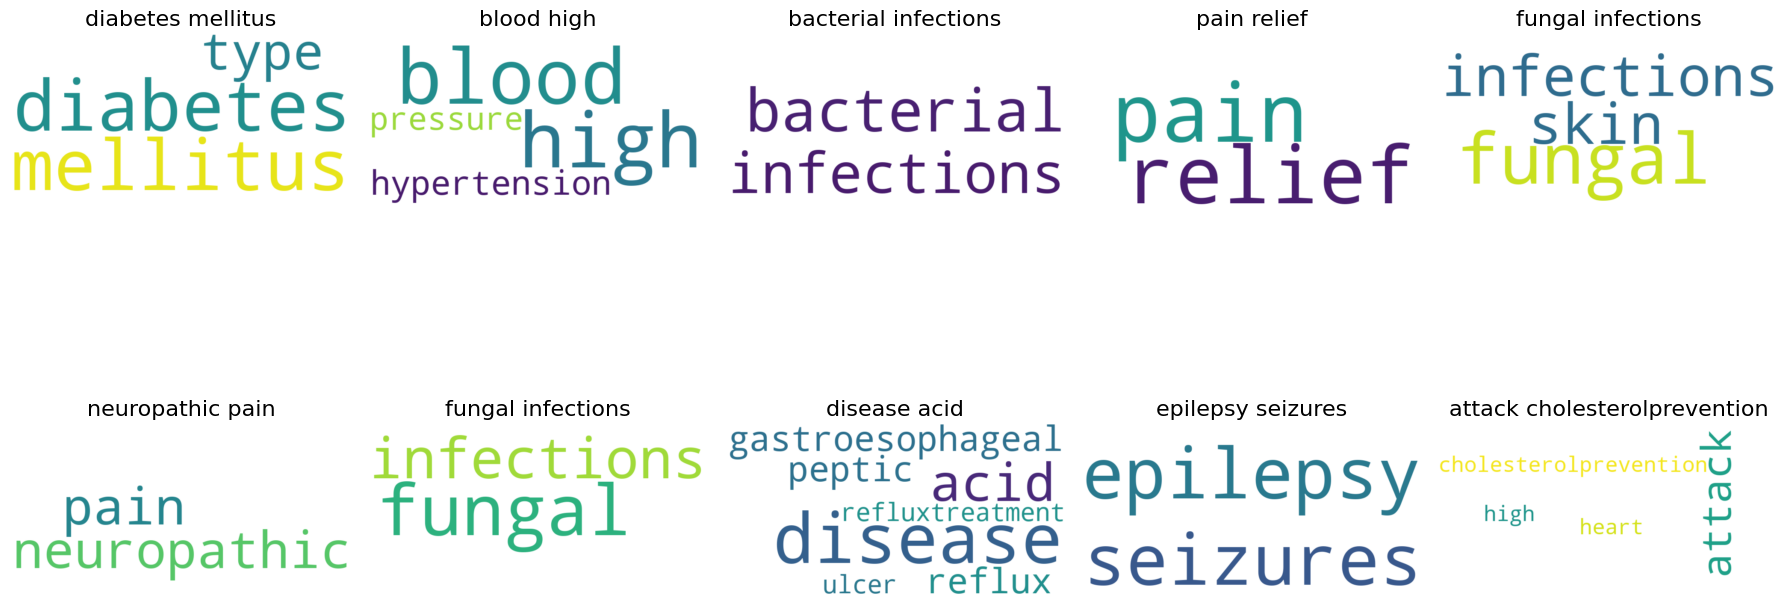

In [42]:
# Set up the 2x5 grid for subplots
fig, axes = plt.subplots(2, 5, figsize=(18, 10))
axes = axes.flatten()

# Generate word clouds and plot for each community
for i, community in enumerate(top_communities):
    # Filter texts for the current community
    community_texts = data[data['Community'] == community]['Uses'].dropna().tolist()
    
    # Skip empty communities
    if not community_texts:
        continue
    
    # Calculate TF-IDF scores
    tfidf_scores = calculate_tfidf(community_texts)
    
    if not tfidf_scores:
        continue  # Skip if no TF-IDF scores are available

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_scores)
    
    # Plot on the respective subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'{community_names.get(community, "Community " + str(community))}', fontsize=16)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('community_wordclouds.png', dpi=300)
plt.show()

Generate Word Clouds for Each Community's 'Composition' Column

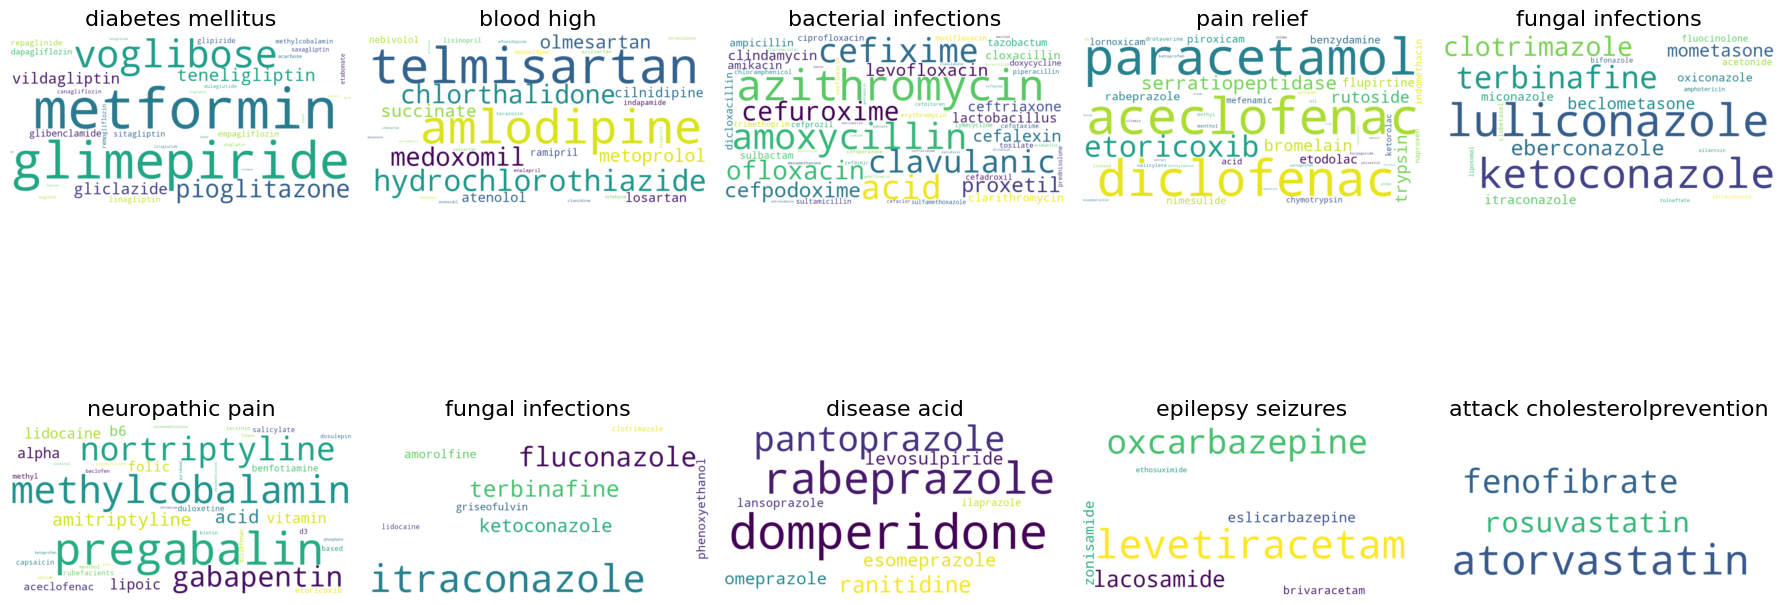

In [43]:
data['Composition'] = data['Composition'].apply(lambda x: clean_text(str(x)))

# Set up the 2x5 grid for subplots
fig, axes = plt.subplots(2, 5, figsize=(18, 10))
axes = axes.flatten()

# Generate word clouds and plot for each community
for i, community in enumerate(top_communities):
    # Filter texts for the current community
    community_texts = data[data['Community'] == community]['Composition'].dropna().tolist()
    
    # Skip empty communities
    if not community_texts:
        continue
    
    # Calculate TF-IDF scores
    tfidf_scores = calculate_tfidf(community_texts)
    
    if not tfidf_scores:
        continue  # Skip if no TF-IDF scores are available

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_scores)
    
    # Plot on the respective subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'{community_names.get(community, "Community " + str(community))}', fontsize=16)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('community_wordclouds.png', dpi=300)
plt.show()

Generate Word Clouds for Each Community's 'Side Effects' Column

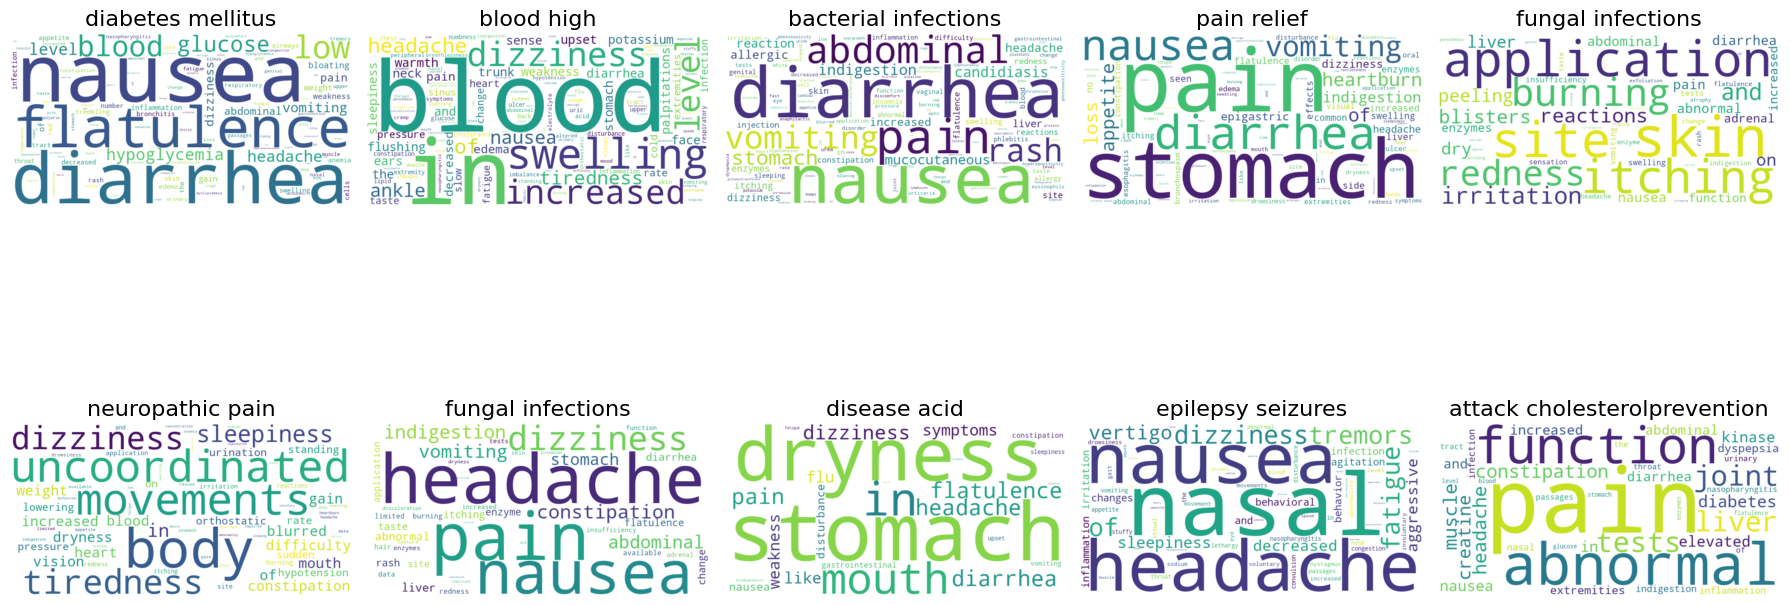

In [44]:
fig, axes = plt.subplots(2, 5, figsize=(18, 10))
axes = axes.flatten()

for i, community in enumerate(top_communities):
    # Filter texts for the current community
    community_texts = data[data['Community'] == community]['Side_effects'].dropna().tolist()
    
    # Skip empty communities
    if not community_texts:
        continue
    
    # Calculate TF-IDF scores
    tfidf_scores = calculate_tfidf(community_texts)
    
    if not tfidf_scores:
        continue  # Skip if no TF-IDF scores are available

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_scores)
    
    # Plot on the respective subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'{community_names.get(community, "Community " + str(community))}', fontsize=16)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('community_wordclouds.png', dpi=300)
plt.show()

## 7. Obsolescence Analysis of Medicines Using TF-IDF, Similarity Metrics, and Community Detection

In this section, the goal is to identify medicines that are likely to become obsolete based on their similarity to other medicines and their associated ratings. By applying TF-IDF analysis to the "Uses" column, we can uncover relationships between medicines based on their descriptions. This is complemented by calculating similarity metrics to group similar medicines, evaluating their ratings, and computing an "obsolescence score" to identify those most at risk.
Steps Overview
- TF-IDF Computation: Applied to transform the "Uses" column of the dataset into numerical representations, capturing the importance of words in medicine descriptions.
- Similarity Matrix Generation: A cosine similarity matrix is computed from the TF-IDF matrix to identify how similar each medicine is to the others.
- Identification of Similar Medicines: Medicines with a similarity score above a set threshold are grouped, allowing for the analysis of their relationship based on shared components.
- Delta Calculation: The average and minimum differences in ratings between a medicine and its similar counterparts are calculated to highlight deviations that contribute to obsolescence.
- Obsolescence Score: A scoring system is established to rank medicines based on their potential obsolescence, taking into account rating discrepancies, the number of similar items, and their baseline rating.
- Community Detection Analysis: The communities used are the one found in section 3 of the notebook. The distance from the community center (obsolescence score) is calculated for each medicine.

In [45]:
def calculate_tfidf(texts):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texts)
    return tfidf_matrix

In [ ]:
# Load data
data = pd.read_csv('data_with_rating_score.csv')

uses = data['Uses'].tolist()
ratings = data['rating_score'].values

tfidf_matrix = calculate_tfidf(uses)

similarity_matrix = cosine_similarity(tfidf_matrix)

similar_meds = {}
threshold = 0.75
for i, row in enumerate(similarity_matrix):
    similar = np.where(row >= threshold)[0]
    similar_meds[i] = similar

medicine_scores = []
for i, rating in enumerate(ratings):
    similar_indices = similar_meds[i]
    if len(similar_indices) > 0:
        similar_ratings = ratings[similar_indices]
        avg_rating = np.mean(similar_ratings)
        min_rating = np.min(similar_ratings)
        
        delta_avg = rating - avg_rating
        delta_min = rating - min_rating
        count_similar = len(similar_indices)
        
        medicine_scores.append({
            'Medicine Name': data['Medicine Name'][i],  # Store index
            'rating': rating,
            'delta_avg': delta_avg,
            'delta_min': delta_min,
            'count_similar': count_similar,
            'Uses': data['Uses'][i]
        })

medicine_df = pd.DataFrame(medicine_scores)


# Filter medicines with at least 3 similar ones or negative delta_avg
filtered_meds = medicine_df[
    (medicine_df['count_similar'] >= 3) | (medicine_df['delta_avg'] < 0)
]
filtered_meds['obsolescence_score'] = (
   - 0.5 * filtered_meds['delta_avg'] - 0.3 * filtered_meds['delta_min'] - 0.2 * filtered_meds['rating']
)

num_to_select = max(1, int(0.05 * len(filtered_meds)))

top_5_percent = filtered_meds.nlargest(num_to_select, 'obsolescence_score')

# print(top_5_percent)
# top_5_percent = top_5_percent.sort_values(by='obsolescence_score', ascending=False)
print("Top 5% Medicines Likely to Become Obsolete:")
top_5_percent[['Medicine Name', 'Uses', 'rating', 'obsolescence_score']]


Top 5% Medicines Likely to Become Obsolete:


/var/folders/4p/kk24d_ts03z6qmxrfh9hyn2c0000gn/T/ipykernel_6125/1423492746.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Medicine Name,Uses,rating,obsolescence_score
3326,Gloritel CT 40 Tablet,Hypertension (high blood pressure),0.00,3.441923
3863,Inditel AH 40 Tablet,Hypertension (high blood pressure),0.00,3.441923
6011,Myotan CT 40/6.25 Tablet,Hypertension (high blood pressure),0.00,3.441923
7310,Olmewon Plus 20 mg Tablet,Hypertension (high blood pressure),0.00,3.441923
8099,Protol 25 TL Tablet PR,Treatment of Hypertension (high blood pressure),0.00,3.441923
...,...,...,...,...
6963,Orthocort 6 Tablet,Treatment of Inflammatory conditionsTreatment ...,0.85,1.405357
5657,Maxogest Tablet,Treatment of AmenorrheaTreatment of Abnormal u...,1.25,1.405000
8728,Rabera-L Capsule,Treatment of Gastroesophageal reflux disease (...,1.65,1.395833
237,Andre Plus Eye Drops,Treatment of Allergic eye disease,2.40,1.395000


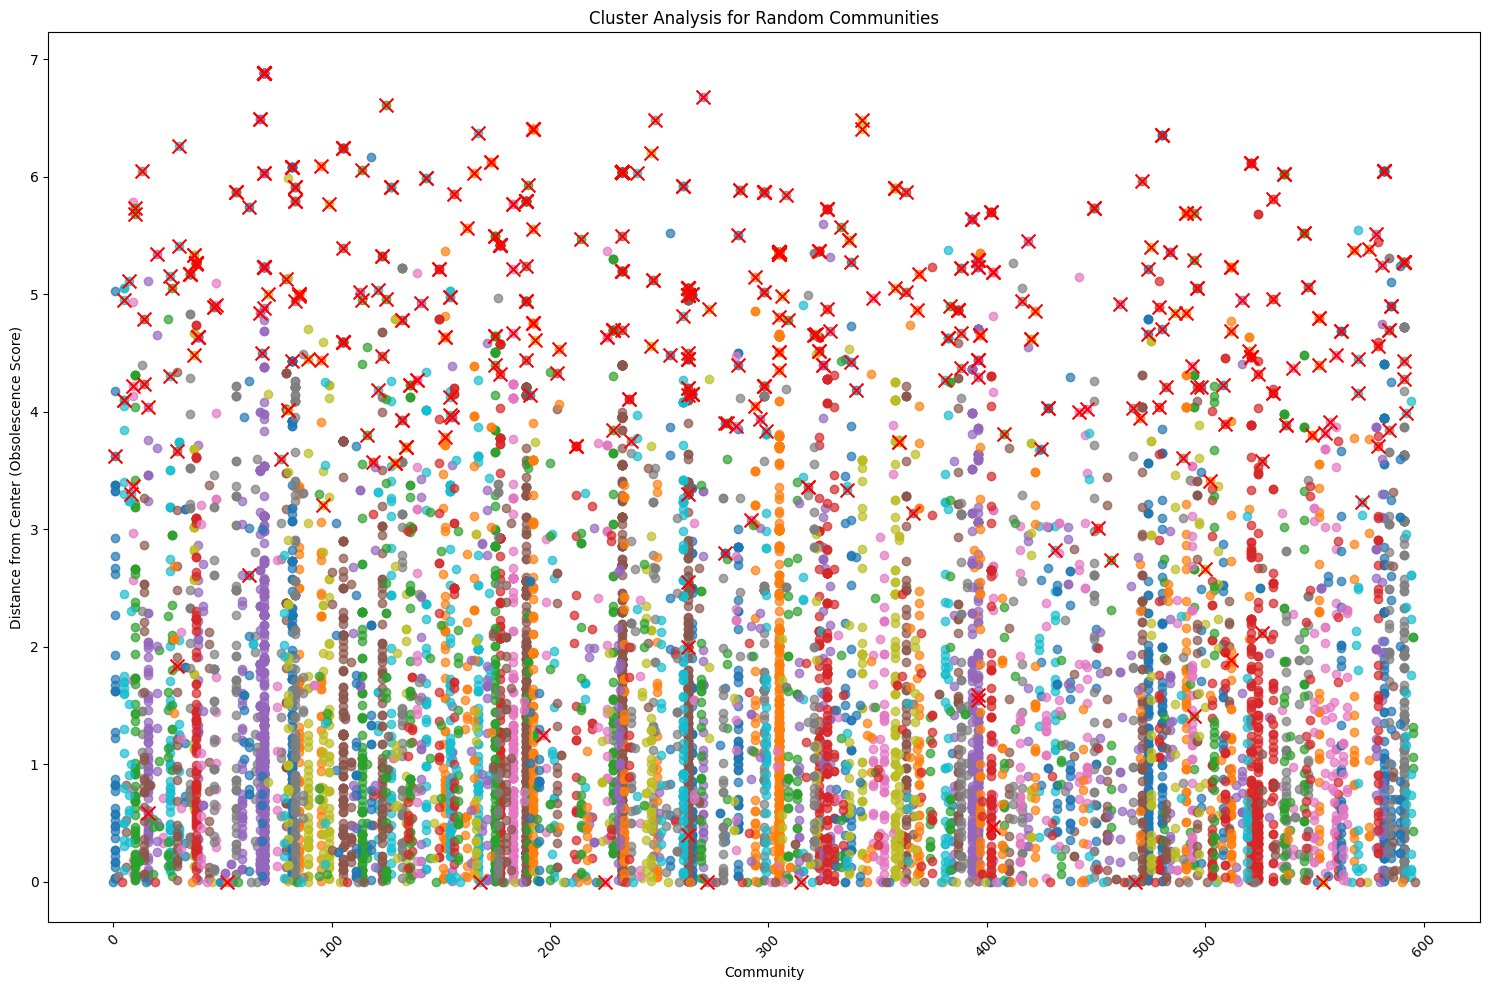

In [ ]:
# Load data
data2 = pd.read_csv('data_with_communities.csv')
data2['obsolescence_score'] = filtered_meds['obsolescence_score']
# data2['medicine_index'] = 
# Step 1: Extract relevant columns
# data2['Community'] = data2.iloc[:, 10]  # 11th column for Community

# random_communities = np.random.choice(data2['Community'].unique(), 50, replace=False)
# filtered_data2 = data2[data2['Community'].isin(random_communities)]

filtered_data2 = data2
random_communities = filtered_data2['Community'].unique()

community_groups = filtered_data2.groupby('Community')
cluster_centers = community_groups['obsolescence_score'].mean()

filtered_data2['distance_from_center'] = filtered_data2.apply(
    lambda row: abs(row['obsolescence_score'] - cluster_centers[row['Community']]),
    axis=1
)

filtered_data2['Medicine Name'] = filtered_data2.iloc[:, 0]

# df1_common = df1[df1["column_name"].isin(df2["column_name"])]:
marked_data = filtered_data2[filtered_data2['Medicine Name'].isin(top_5_percent['Medicine Name'])]
# else:
#     marked_data = pd.DataFrame()

plt.figure(figsize=(15, 10))

# Plot the data for each random community
for community in random_communities:
    community_data = filtered_data2[filtered_data2['Community'] == community]
    
    # Scatter plot for community data
    plt.scatter(
        [community] * len(community_data),  # x-axis: Community ID
        community_data['distance_from_center'],  # y-axis: distance from center
        label=f"Community {community}",
        alpha=0.7,
    )

# Scatter plot for marked data
plt.scatter(
    marked_data['Community'],  # x-axis: Community ID
    marked_data['distance_from_center'],  # y-axis: distance from center
    color='red',
    marker='x',
    s=100,  # Size of the marker
)

# Adding labels and title
plt.xlabel("Community")
plt.ylabel("Distance from Center (Obsolescence Score)")
plt.title("Cluster Analysis for Random Communities")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()

# Show the plot
plt.show()